In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

# Data preprocessing

In [33]:
import yfinance as yf

aapl = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
aapl = aapl['Close']
aapl.head(10)

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2015-01-02,24.261044
2015-01-05,23.577578
2015-01-06,23.579800
2015-01-07,23.910440
2015-01-08,24.829130
2015-01-09,24.855753
2015-01-12,24.243290
2015-01-13,24.458544
2015-01-14,24.365351


In [41]:
df = aapl
df.head()

Ticker,AAPL
Date,
2015-01-02,24.261044
2015-01-05,23.577578
2015-01-06,23.579800
2015-01-07,23.910440
2015-01-08,24.829130


In [42]:
df.tail()

Ticker,AAPL
Date,
2024-12-23,254.367020
2024-12-24,257.286682
2024-12-26,258.103729
2024-12-27,254.685867
2024-12-30,251.307877


In [43]:
df = df.fillna(method = 'ffill')
df.tail(10)

Ticker,AAPL
Date,
2024-12-16,250.151978
2024-12-17,252.583344
2024-12-18,247.172562
2024-12-19,248.906403
2024-12-20,253.589783
2024-12-23,254.367020
2024-12-24,257.286682
2024-12-26,258.103729
2024-12-27,254.685867


In [44]:
df['LogAAPL']= np.log(df['AAPL'])
df

Ticker,AAPL,LogAAPL
Date,,
2015-01-02,24.261044,3.188872
2015-01-05,23.577578,3.160296
2015-01-06,23.579800,3.160390
2015-01-07,23.910440,3.174315
2015-01-08,24.829130,3.212018
...,...,...
2024-12-23,254.367020,5.538778
2024-12-24,257.286682,5.550191
2024-12-26,258.103729,5.553362


In [46]:
df2 = df.copy()
df2.shape

(2515, 2)

In [48]:
test_period = int(len(df) * 0.2)
train_period = len(df) - test_period

print("train_period:", train_period)
print("test_period:", test_period)

train_period: 2012
test_period: 503


In [49]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]

In [50]:
series = df['LogAAPL'].dropna().to_numpy()

Tx = 60 # using the past observations to forecast the next one.
Ty = 1 # forecasting only one step ahead
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Tx, 1)
Y = np.array([series[t+Tx+Ty-1] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Ty)
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (2455, 60, 1) Y: (2455, 1) N: 2455


In [51]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [53]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((1952, 60, 1), (1952, 1), (503, 60, 1), (503, 1))

# One-step Forecast

Model Training

In [ ]:
n_features = 1 
inputs = keras.Input(shape=(Tx, n_features))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_aapl_forecast_60d.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain,
                    epochs=100,
                    validation_data=(Xtest,Ytest),
                    callbacks=callbacks)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.8765 - mae: 1.4640 - val_loss: 0.5857 - val_mae: 0.7541
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0285 - mae: 0.1296 - val_loss: 0.0463 - val_mae: 0.1888
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152 - mae: 0.0971 - val_loss: 0.0246 - val_mae: 0.1263
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0133 - mae: 0.0949 - val_loss: 0.0170 - val_mae: 0.0995
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0122 - mae: 0.0935 - val_loss: 0.0315 - val_mae: 0.1540
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0107 - mae: 0.0903 - val_loss: 0.0860 - val_mae: 0.2828
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0103 - mae: 0.0848 - val_loss: 0.0194 - val_mae: 0.1110
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0091 - mae: 0.0781 - val_loss: 0.0090 - val_mae: 0.0760
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

In [ ]:
model = tf.keras.models.load_model('lstm_aapl_forecast_60d.keras')

In [56]:
train_predictions = model.predict(Xtrain)
test_predictions = model.predict(Xtest)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [58]:
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

train_indicator[:Tx] = False

df.loc[train_indicator, '1step_train'] =  train_predictions
df.loc[test_indicator, '1step_test'] =  test_predictions

df['1step_train_orig'] = np.exp(df['1step_train'])
df['1step_test_orig'] = np.exp(df['1step_test'])

In [59]:
df.iloc[899:]

Ticker,AAPL,LogAAPL,1step_train,1step_test,1step_train_orig,1step_test_orig
Date,,,,,,
2018-07-30,44.872368,3.803822,3.880297,NaN,48.438583,NaN
2018-07-31,44.962154,3.805821,3.873314,NaN,48.101543,NaN
2018-08-01,47.610874,3.863061,3.869148,NaN,47.901566,NaN
2018-08-02,49.002571,3.891873,3.892217,NaN,49.019451,NaN
2018-08-03,49.144341,3.894762,3.921522,NaN,50.477200,NaN
...,...,...,...,...,...,...
2024-12-23,254.367020,5.538778,NaN,5.460409,NaN,235.193527
2024-12-24,257.286682,5.550191,NaN,5.464734,NaN,236.212921
2024-12-26,258.103729,5.553362,NaN,5.471295,NaN,237.767883


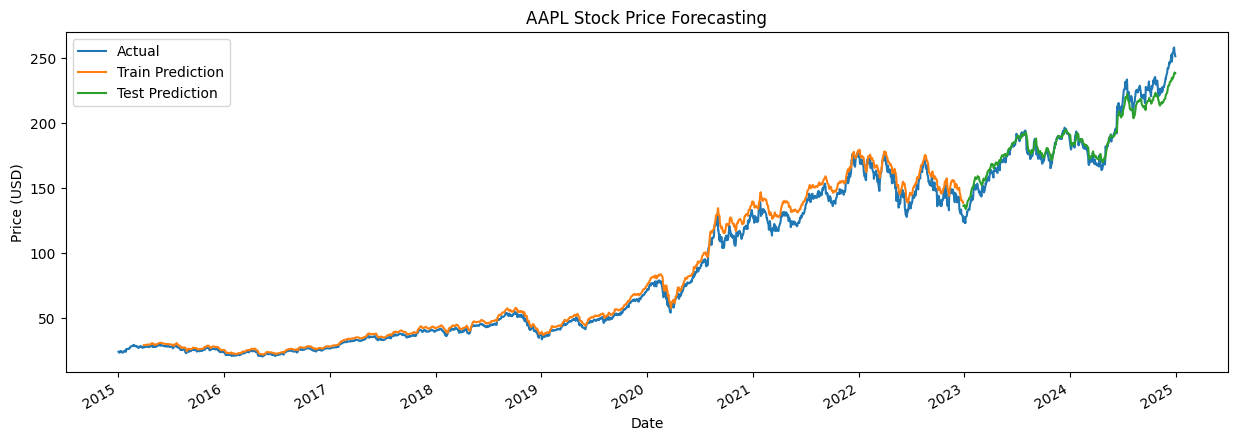

In [61]:
df_plot = df[['AAPL', '1step_train_orig', '1step_test_orig']].plot(figsize=(15, 5))
df_plot.set_title('AAPL Stock Price Forecasting')
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Price (USD)')
df_plot.legend(['Actual', 'Train Prediction', 'Test Prediction'])

plt.show()

# Multi-Step

Using the same model

In [62]:
multistep_predictions = []

# first test input
last_x = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The last_x array, which serves as input for the next prediction, is updated. The np.roll(last_x, -1) shifts all elements of last_x one position to the left. 
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [63]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions

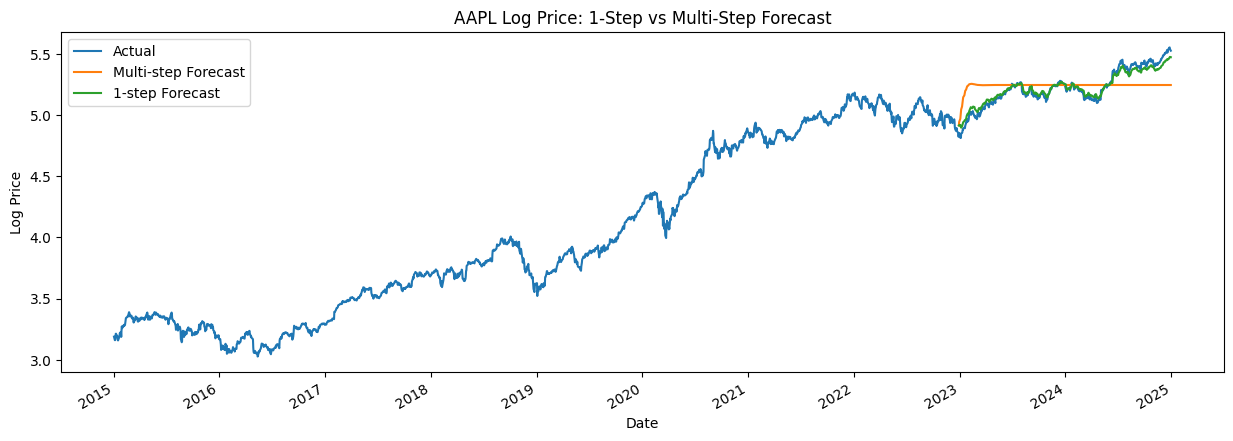

In [64]:
df_plot_both = df[['LogAAPL', 'multistep_test', '1step_test']].plot(figsize=(15, 5))
df_plot_both.set_title('AAPL Log Price: 1-Step vs Multi-Step Forecast')
df_plot_both.set_xlabel('Date')
df_plot_both.set_ylabel('Log Price')
df_plot_both.legend(['Actual', 'Multi-step Forecast', '1-step Forecast'])

plt.show()

Using new model

In [72]:
n_features = 1 
n_outputs = test_period   # predict 10 steps into the future

inputs = keras.Input(shape=(Tx, n_features))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(n_outputs)(x)   # <--- multiple outputs
model2 = keras.Model(inputs, outputs)

model2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

y_pred = model2.predict(Xtest)  # shape (num_samples, 10)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


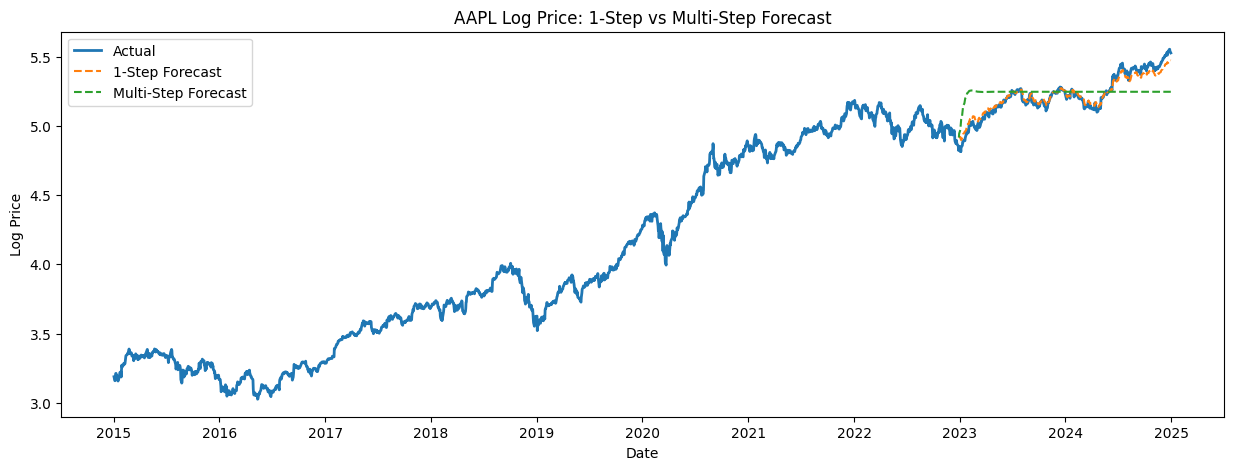

In [ ]:
# Plot actual vs one-step vs multi-step forecast
plt.figure(figsize=(15,5))

plt.plot(df.index, df['LogAAPL'], label="Actual", linewidth=2)
plt.plot(df.index, df['1step_test'], label="1-Step Forecast", linestyle="--")
plt.plot(df.index, df['multistep_test'], label="Multi-Step Forecast", linestyle="--")

plt.title("AAPL Log Price: 1-Step vs Multi-Step Forecast")
plt.xlabel("Date")
plt.ylabel("Log Price")
plt.legend()
plt.show()

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

print("MSE (one-step):", mean_squared_error(Ytest, test_predictions))
print("MAE (one-step):", mean_absolute_error(Ytest, test_predictions))

print()

print("MSE (multi-step):", mean_squared_error(Ytest, multistep_predictions))
print("MAE (multi-step):", mean_absolute_error(Ytest, multistep_predictions))

MSE (one-step): 0.0012219515462817865
MAE (one-step): 0.02798777117673169

MSE (multi-step): 0.020072761478817116
MAE (multi-step): 0.11610966753468882
